In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import glob

In [2]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "FairClassifier" : "#a6d854",
    "MMBFair" : "#8da0cb",
    "MMBFair_grad" : "#66c2a5",
    "FairGBMClassifier_eod" : "#fdb462",
    "MMBFair_eod" : "#b3de69",
    "MMBFair_grad_eod" : "#fccde5"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "FairClassifier" : "FairClassifier",
    "FairGBMClassifier" : "FairGBM",
    "MMBFair" : "M²FGB",
    "MMBFair_grad" : "M²FGB-grad",
    "FairGBMClassifier_eod" : "FairGBM (EOD)",
    "MMBFair_eod" : "M²FGB (EOD)",
    "MMBFair_grad_eod" : "M²FGB-grad (EOD)"
}
metrics_names = {
    "tpr" : "TPR",
    "bal_acc" : "Bal. Acc.",
}

In [19]:
handles = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items()
]

## Experiment 1

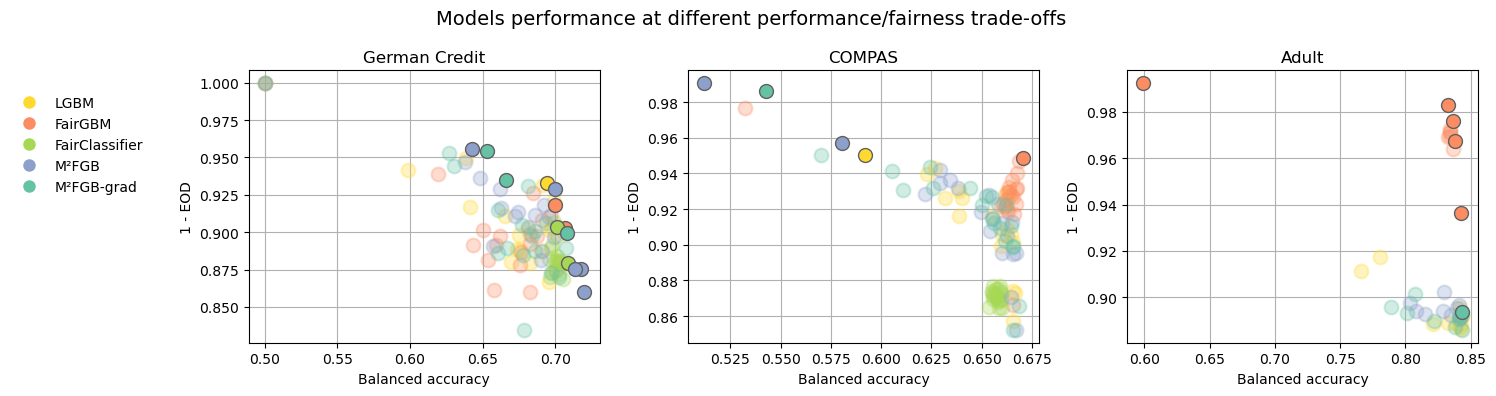

In [16]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

selected_models = ["LGBMClassifier", "FairGBMClassifier", "FairClassifier", "MMBFair", "MMBFair_grad"]
alphas = [0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

handles = [
    Line2D([0], [0], marker='o', color='w', label=methods_names["LGBMClassifier"], markerfacecolor=methods_color["LGBMClassifier"], markersize=10),
    Line2D([0], [0], marker='o', color='w', label=methods_names["FairGBMClassifier"], markerfacecolor=methods_color["FairGBMClassifier"], markersize=10),
    Line2D([0], [0], marker='o', color='w', label=methods_names["FairClassifier"], markerfacecolor=methods_color["FairClassifier"], markersize=10),
    Line2D([0], [0], marker='o', color='w', label=methods_names["MMBFair"], markerfacecolor=methods_color["MMBFair"], markersize=10),
    Line2D([0], [0], marker='o', color='w', label=methods_names["MMBFair_grad"], markerfacecolor=methods_color["MMBFair_grad"], markersize=10),
]

for k, dataset in enumerate(["german", "compas", "adult"]):
    results = []
    for i, alpha in enumerate(alphas):
        for j, model in enumerate(selected_models):
            folder = f"../results/group_experiment/{dataset}/{model}_{alpha}"
            try:
                df = pd.read_csv(folder + "/results.csv")
                df["model"] = model
                df["fair"] = 1 - abs(df["eod"])
                df = df[["model", "bal_acc", "fair"]]
                df = df.groupby("model").mean().reset_index()
                results.append(df)
            except:
                continue
        

    results = pd.concat(results).reset_index(drop=True)


    
    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] <= row2["bal_acc"] and row["fair"] <= row2["fair"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated

    for model in selected_models:
        df_dominated = results[(results["model"] == model) & (results["dominated"] == True)]
        df_not_dominated = results[(results["model"] == model) & (results["dominated"] == False)]
        
        axs[k].scatter(
            df_dominated["bal_acc"], 
            df_dominated["fair"], 
            c = methods_color[model],
            label=model,
            alpha = 0.3,
            s = 100,
            lw = 1.5,
            zorder = 5,
        )

        axs[k].scatter(
            df_not_dominated["bal_acc"], 
            df_not_dominated["fair"], 
            c = methods_color[model],
            label=model,
            alpha = 1,
            s = 100,
            lw = 1,
            zorder = 10,
            ec = "#606060",

        )

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel("Balanced accuracy")
    axs[k].set_ylabel("1 - EOD")
    if k == 0:
        axs[k].legend(handles=handles, loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
        #axs[0].legend(loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)



plt.suptitle("Models performance at different performance/fairness trade-offs", fontsize=14)

plt.tight_layout()
#plt.savefig("../figs/group_experiment.pdf", dpi = 300)

In [15]:
selected_models = ["LGBMClassifier", "FairClassifier", "FairGBMClassifier", "MMBFair", "MMBFair_grad"]

for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    #models = glob.glob(f"../results/group_experiment/{dataset}/*0.7")
    models = [f"../results/group_experiment/{dataset}/{model}_0.7" for model in selected_models]
    # remove the ones that don't exist
    models = [model for model in models if len(glob.glob(model)) > 0]
    results_mean = []
    results_std = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])

        df = pd.read_csv(model + "/results.csv").iloc[:, 1:]
        df["model"] = model_name
        df["fair"] = 1 - abs(df["eod"])
        df = df[["model", "bal_acc", "fair"]]
        df_mean = df.groupby("model").mean().reset_index()
        df_std = df.groupby("model").std().reset_index()

        results_mean.append(df_mean)
        results_std.append(df_std)
    
    results_mean = pd.concat(results_mean).reset_index(drop=True).round(2)
    results_std = pd.concat(results_std).reset_index(drop=True).round(2)

    results_mean["bal_acc"] = "$" + results_mean["bal_acc"].astype(str) + "(\pm " + results_std["bal_acc"].astype(str) +  ")$" 
    results_mean["fair"] =   "$" +results_mean["fair"].astype(str) + "(\pm " + results_std["fair"].astype(str) +  ")$" 

    print(dataset_names[dataset])
    print(results_mean)
    print("\n\n")

    

German Credit
               model           bal_acc              fair
0     LGBMClassifier  $0.68(\pm 0.05)$  $0.89(\pm 0.07)$
1     FairClassifier   $0.7(\pm 0.05)$  $0.88(\pm 0.09)$
2  FairGBMClassifier  $0.68(\pm 0.04)$  $0.88(\pm 0.09)$
3            MMBFair  $0.69(\pm 0.04)$   $0.89(\pm 0.1)$
4       MMBFair_grad  $0.68(\pm 0.04)$  $0.88(\pm 0.09)$



COMPAS
               model           bal_acc              fair
0     LGBMClassifier  $0.66(\pm 0.02)$  $0.92(\pm 0.05)$
1     FairClassifier  $0.66(\pm 0.01)$  $0.87(\pm 0.04)$
2  FairGBMClassifier  $0.66(\pm 0.02)$  $0.92(\pm 0.05)$
3            MMBFair  $0.66(\pm 0.01)$   $0.9(\pm 0.06)$
4       MMBFair_grad  $0.66(\pm 0.01)$  $0.91(\pm 0.07)$



Adult
               model           bal_acc              fair
0     LGBMClassifier   $0.84(\pm 0.0)$  $0.89(\pm 0.04)$
1  FairGBMClassifier  $0.83(\pm 0.01)$  $0.97(\pm 0.03)$
2            MMBFair   $0.84(\pm 0.0)$  $0.89(\pm 0.03)$
3       MMBFair_grad  $0.84(\pm 0.01)$  $0.89(\pm 0.04)

## Experiment 2 and 3

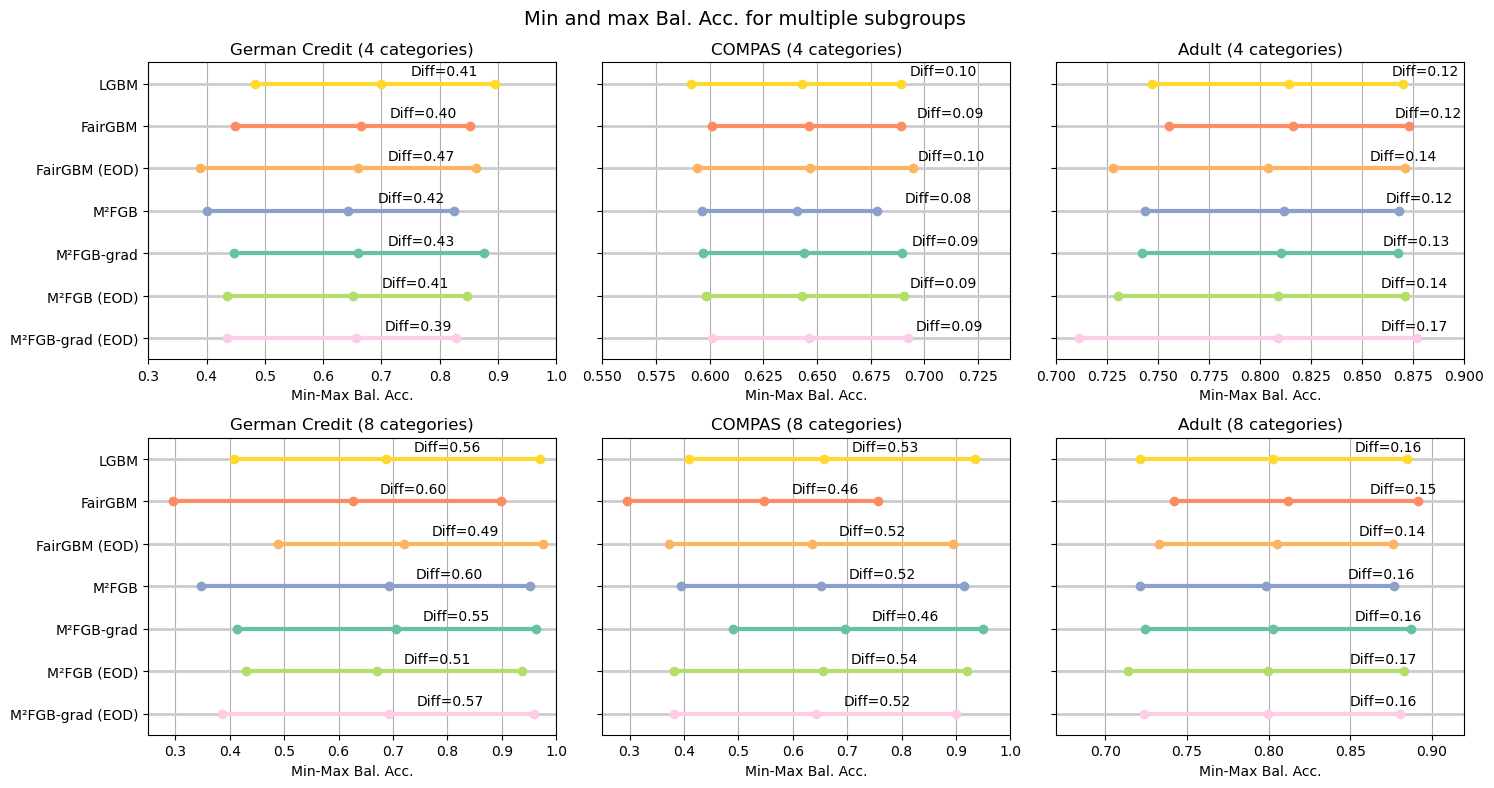

In [35]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8), sharey=True, sharex = False)
axs = axs.flatten()

metric = "bal_acc"
selected_models = [
    "LGBMClassifier", 
    "FairGBMClassifier", 
    "FairGBMClassifier_eod", 
    "MMBFair", 
    "MMBFair_grad",  
    "MMBFair_eod", 
    "MMBFair_grad_eod"
][::-1]

for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = [f"../results/subgroup_experiment/{dataset}/{model}_0.75" for model in selected_models]
    models = [model for model in models if len(glob.glob(model)) > 0]
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv")
        df["model"] = model_name
        df = df[["model", f"{metric}_min", f"{metric}_max", f"{metric}_mean"]]
        df_std = df.groupby("model").std().reset_index()
        df = df.groupby("model").mean().reset_index()
        
        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_ = df[f"{metric}_min"].values[0]
        mean_ = df[f"{metric}_mean"].values[0]
        max_ = df[f"{metric}_max"].values[0]
        axs[k].plot([0, 1], [i, i], color="#cccccc", linewidth=2)
        axs[k].plot([min_, mean_, max_], [i, i, i], label=model, linewidth=3, marker="o", color=methods_color[model], alpha = 1)
        # draw black line
        

      
        axs[k].annotate(f"Diff={max_ - min_:.2f}", xy=(mean_, i), xytext=(mean_ + 0.05, i + 0.2), fontsize=10)
        

    # make only vertical grid
    axs[k].grid(axis="x")
    axs[k].set_title(dataset_names[dataset] + " (4 categories)")
    axs[k].set_xlabel(f"Min-Max {metrics_names[metric]}")
    axs[k].set_ylim(-0.5, len(selected_models) - 0.5)
    axs[k].set_yticks(range(len(selected_models)))
    axs[k].set_yticklabels([methods_names[model] for model in selected_models])

axs[0].set_xlim(0.3, 1)
axs[1].set_xlim(0.55, 0.74)
axs[2].set_xlim(0.7, 0.9)

axs = axs[-3:]

for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = [f"../results/subgroup2_experiment/{dataset}/{model}_0.75" for model in selected_models]
    models = [model for model in models if len(glob.glob(model)) > 0]
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv")
        df["model"] = model_name
        df = df[["model", f"{metric}_min", f"{metric}_max", f"{metric}_mean"]]
        df_std = df.groupby("model").std().reset_index()
        df = df.groupby("model").mean().reset_index()
        
        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_ = df[f"{metric}_min"].values[0]
        mean_ = df[f"{metric}_mean"].values[0]
        max_ = df[f"{metric}_max"].values[0]
        axs[k].plot([0, 1], [i, i], color="#cccccc", linewidth=2)
        axs[k].plot([min_, mean_, max_], [i, i, i], label=model, linewidth=3, marker="o", color=methods_color[model], alpha = 1)
        # draw black line
        

      
        axs[k].annotate(f"Diff={max_ - min_:.2f}", xy=(mean_, i), xytext=(mean_ + 0.05, i + 0.2), fontsize=10)
        

    # make only vertical grid
    axs[k].grid(axis="x")
    axs[k].set_title(dataset_names[dataset] + " (8 categories)")
    axs[k].set_xlabel(f"Min-Max {metrics_names[metric]}")
    axs[k].set_ylim(-0.5, len(selected_models) - 0.5)
    axs[k].set_yticks(range(len(selected_models)))
    axs[k].set_yticklabels([methods_names[model] for model in selected_models])

axs[0].set_xlim(0.25, 1)
axs[1].set_xlim(0.25, 1)
axs[2].set_xlim(0.67, 0.92)


plt.suptitle("Min and max Bal. Acc. for multiple subgroups", fontsize=14)
plt.tight_layout()
plt.savefig("../figs/subgroup_experiment.pdf", dpi = 300)
plt.show()

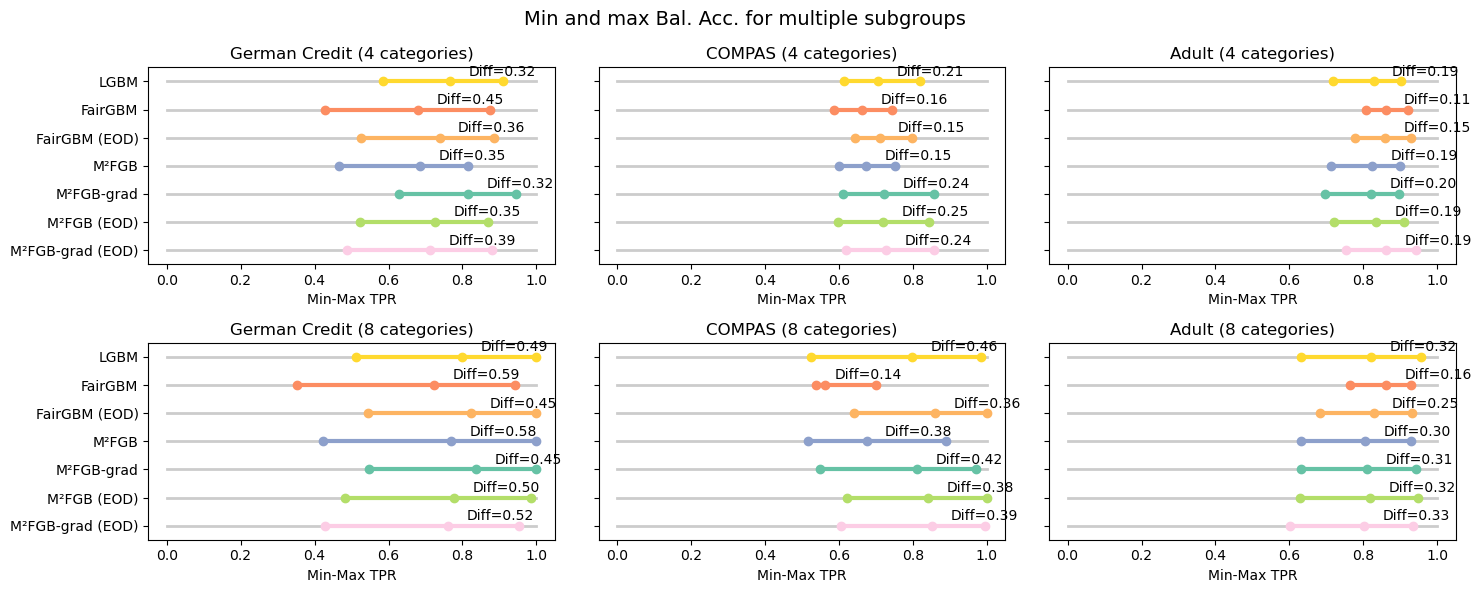

In [33]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 6), sharey=True, sharex = False)
axs = axs.flatten()

metric = "tpr"
selected_models = [
    "LGBMClassifier", 
    "FairGBMClassifier", 
    "FairGBMClassifier_eod", 
    "MMBFair", 
    "MMBFair_grad",  
    "MMBFair_eod", 
    "MMBFair_grad_eod"
][::-1]

for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = [f"../results/subgroup_experiment/{dataset}/{model}_0.75" for model in selected_models]
    models = [model for model in models if len(glob.glob(model)) > 0]
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv")
        df["model"] = model_name
        df = df[["model", f"{metric}_min", f"{metric}_max", f"{metric}_mean"]]
        df_std = df.groupby("model").std().reset_index()
        df = df.groupby("model").mean().reset_index()
        
        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_ = df[f"{metric}_min"].values[0]
        mean_ = df[f"{metric}_mean"].values[0]
        max_ = df[f"{metric}_max"].values[0]
        axs[k].plot([0, 1], [i, i], color="#cccccc", linewidth=2)
        axs[k].plot([min_, mean_, max_], [i, i, i], label=model, linewidth=3, marker="o", color=methods_color[model], alpha = 1)
        # draw black line
        

      
        axs[k].annotate(f"Diff={max_ - min_:.2f}", xy=(mean_, i), xytext=(mean_ + 0.05, i + 0.2), fontsize=10)
        

    # make only vertical grid
    #axs[k].grid(axis="x")
    axs[k].set_title(dataset_names[dataset] + " (4 categories)")
    axs[k].set_xlabel(f"Min-Max {metrics_names[metric]}")
    axs[k].set_ylim(-0.5, len(selected_models) - 0.5)
    axs[k].set_yticks(range(len(selected_models)))
    axs[k].set_yticklabels([methods_names[model] for model in selected_models])

#axs[0].set_xlim(0.3, 1)
#axs[1].set_xlim(0.55, 0.74)
#axs[2].set_xlim(0.7, 0.9)

axs = axs[-3:]

for k, dataset in enumerate(["german", "compas", "adult"]):
    # load tables
    models = [f"../results/subgroup2_experiment/{dataset}/{model}_0.75" for model in selected_models]
    models = [model for model in models if len(glob.glob(model)) > 0]
    results = []
    for model in models:
        model_name = "_".join(model.split("/")[-1].split("_")[:-1])
        alpha = float(model.split("_")[-1])
        df = pd.read_csv(model + "/results.csv")
        df["model"] = model_name
        df = df[["model", f"{metric}_min", f"{metric}_max", f"{metric}_mean"]]
        df_std = df.groupby("model").std().reset_index()
        df = df.groupby("model").mean().reset_index()
        
        results.append(df)

    results = pd.concat(results).reset_index(drop=True)
    
    for i, model in enumerate(selected_models):
        df = results[results["model"] == model]
        min_ = df[f"{metric}_min"].values[0]
        mean_ = df[f"{metric}_mean"].values[0]
        max_ = df[f"{metric}_max"].values[0]
        axs[k].plot([0, 1], [i, i], color="#cccccc", linewidth=2)
        axs[k].plot([min_, mean_, max_], [i, i, i], label=model, linewidth=3, marker="o", color=methods_color[model], alpha = 1)
        # draw black line
        

      
        axs[k].annotate(f"Diff={max_ - min_:.2f}", xy=(mean_, i), xytext=(mean_ + 0.05, i + 0.2), fontsize=10)
        

    # make only vertical grid
    #axs[k].grid(axis="x")
    axs[k].set_title(dataset_names[dataset] + " (8 categories)")
    axs[k].set_xlabel(f"Min-Max {metrics_names[metric]}")
    axs[k].set_ylim(-0.5, len(selected_models) - 0.5)
    axs[k].set_yticks(range(len(selected_models)))
    axs[k].set_yticklabels([methods_names[model] for model in selected_models])

#axs[0].set_xlim(0.25, 1)
#axs[1].set_xlim(0.25, 1)
#axs[2].set_xlim(0.67, 0.92)


plt.suptitle("Min and max Bal. Acc. for multiple subgroups", fontsize=14)
plt.tight_layout()
#plt.savefig("../figs/subgroup_experiment.pdf", dpi = 300)
plt.show()

## Experiment 4

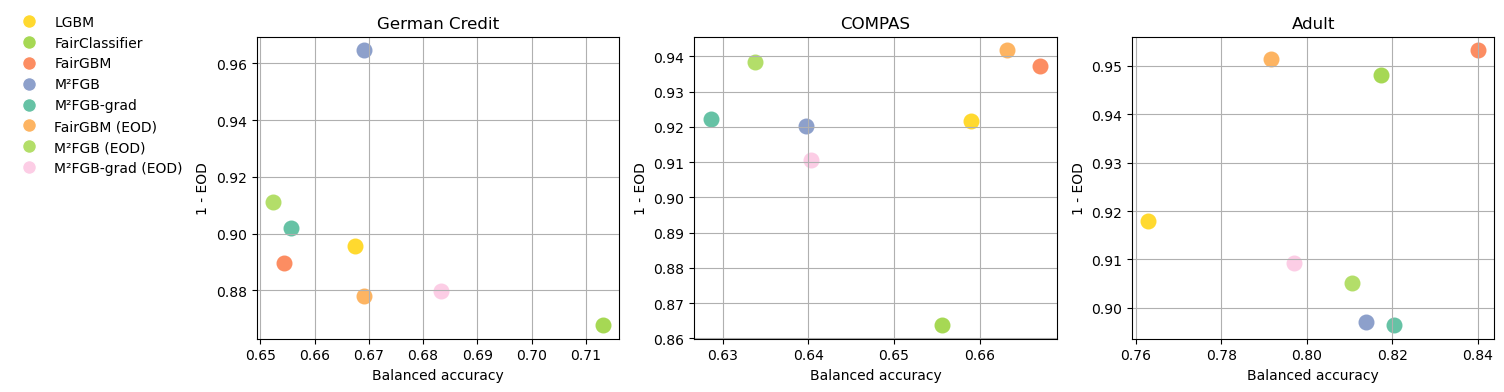

In [10]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

selected_models = ["LGBMClassifier", "FairGBMClassifier", "FairClassifier", "MMBFair", "MMBFair_grad", "FairGBMClassifier_eod", "MMBFair_eod", "MMBFair_grad_eod"]

for k, dataset in enumerate(["german", "compas", "adult"]):
    results = []
    for i, model in enumerate(selected_models):
        folder = f"../results/fairness_goal_experiment/{dataset}/{model}_0.95"
        try:
            df = pd.read_csv(folder + "/results.csv")
            df["model"] = model
            df["fair"] = 1 - abs(df["eod"])
            df = df[["model", "bal_acc", "fair"]]
            df = df.groupby("model").mean().reset_index()
            results.append(df)
        except:
            continue
        

    results = pd.concat(results).reset_index(drop=True)


    dominated = []
    for i, row in results.iterrows():
        is_dominated = False
        for j, row2 in results.iterrows():
            if i == j:
                continue
            if row["bal_acc"] <= row2["bal_acc"] and row["fair"] <= row2["fair"]:
                is_dominated = True
                break
        dominated.append(is_dominated)
    results["dominated"] = dominated

    for model in selected_models:
        df = results[results["model"] == model]
        axs[k].scatter(
            df["bal_acc"], 
            df["fair"],
            c = methods_color[model],
            #label=model,
            #alpha = [0.3 if dominated else 1 for dominated in df["dominated"]],  
            s = 100,
            lw = 1.5
        )

    axs[k].grid()
    axs[k].set_title(dataset_names[dataset])
    axs[k].set_xlabel("Balanced accuracy")
    axs[k].set_ylabel("1 - EOD")
    if k == 0:
        axs[k].legend(handles=handles, loc="lower left", bbox_to_anchor=(-0.7, 0.5), frameon=False)
plt.tight_layout()

In [11]:

selected_models = ["LGBMClassifier", "FairClassifier", "FairGBMClassifier", "FairGBMClassifier_eod", "MMBFair", "MMBFair_grad", "MMBFair_grad_eod", "MMBFair_eod"]

for k, dataset in enumerate(["german", "compas", "adult"]):
    results_mean = []
    results_std = []
    for i, model in enumerate(selected_models):
        folder = f"../results/fairness_goal_experiment/{dataset}/{model}_0.95"
        try:
            df = pd.read_csv(folder + "/results.csv")
            df["model"] = model
            df["fair"] = 1 - abs(df["eod"])
            df = df[["model", "bal_acc", "fair"]]
            df_mean = df.groupby("model").mean().reset_index()
            df_std = df.groupby("model").std().reset_index()
            results_mean.append(df_mean)
            results_std.append(df_std)
        except:
            continue
        

    results_mean = pd.concat(results_mean).reset_index(drop=True).round(2)
    results_std = pd.concat(results_std).reset_index(drop=True).round(2)

    results_mean["bal_acc"] = "$" + results_mean["bal_acc"].astype(str) + "(\pm " + results_std["bal_acc"].astype(str) +  ")$"
    results_mean["fair"] =   "$" +results_mean["fair"].astype(str) + "(\pm " + results_std["fair"].astype(str) +  ")$"

    print(dataset_names[dataset])
    print(results_mean)

German Credit
                   model           bal_acc              fair
0         LGBMClassifier  $0.67(\pm 0.05)$   $0.9(\pm 0.07)$
1         FairClassifier  $0.71(\pm 0.04)$  $0.87(\pm 0.11)$
2      FairGBMClassifier  $0.65(\pm 0.06)$  $0.89(\pm 0.09)$
3  FairGBMClassifier_eod  $0.67(\pm 0.04)$  $0.88(\pm 0.08)$
4                MMBFair  $0.67(\pm 0.08)$  $0.96(\pm 0.03)$
5           MMBFair_grad  $0.66(\pm 0.08)$   $0.9(\pm 0.09)$
6       MMBFair_grad_eod  $0.68(\pm 0.05)$  $0.88(\pm 0.08)$
7            MMBFair_eod  $0.65(\pm 0.07)$  $0.91(\pm 0.09)$
COMPAS
                   model           bal_acc              fair
0         LGBMClassifier  $0.66(\pm 0.02)$  $0.92(\pm 0.06)$
1         FairClassifier  $0.66(\pm 0.01)$  $0.86(\pm 0.04)$
2      FairGBMClassifier  $0.67(\pm 0.01)$  $0.94(\pm 0.06)$
3  FairGBMClassifier_eod  $0.66(\pm 0.01)$  $0.94(\pm 0.05)$
4                MMBFair  $0.64(\pm 0.05)$  $0.92(\pm 0.06)$
5           MMBFair_grad  $0.63(\pm 0.07)$  $0.92(\pm 0.07)$
6  

## Experiment 5 SPD

In [13]:

selected_models = ["LGBMClassifier_spd", "FairClassifier_spd", "MMBFair_grad_spd", "MMBFair_spd"]

for k, dataset in enumerate(["german", "compas", "adult"]):
    results_mean = []
    results_std = []
    for i, model in enumerate(selected_models):
        folder = f"../results/group_experiment/{dataset}/{model}_0.7"
        try:
            df = pd.read_csv(folder + "/results.csv")
            df["model"] = model
            df["fair"] = 1 - abs(df["spd"])
            df = df[["model", "bal_acc", "fair"]]
            df_mean = df.groupby("model").mean().reset_index()
            df_std = df.groupby("model").std().reset_index()
            results_mean.append(df_mean)
            results_std.append(df_std)
        except:
            continue
        

    results_mean = pd.concat(results_mean).reset_index(drop=True).round(2)
    results_std = pd.concat(results_std).reset_index(drop=True).round(2)

    results_mean["bal_acc"] = "$" + results_mean["bal_acc"].astype(str) + "(\pm " + results_std["bal_acc"].astype(str) +  ")$"
    results_mean["fair"] =   "$" +results_mean["fair"].astype(str) + "(\pm " + results_std["fair"].astype(str) +  ")$"

    print(dataset_names[dataset])
    print(results_mean)

German Credit
                model           bal_acc              fair
0  LGBMClassifier_spd  $0.69(\pm 0.05)$  $0.93(\pm 0.06)$
1  FairClassifier_spd  $0.69(\pm 0.04)$   $0.9(\pm 0.08)$
2    MMBFair_grad_spd   $0.7(\pm 0.03)$   $0.9(\pm 0.06)$
3         MMBFair_spd  $0.67(\pm 0.06)$  $0.93(\pm 0.05)$
COMPAS
                model           bal_acc              fair
0  LGBMClassifier_spd  $0.66(\pm 0.02)$  $0.85(\pm 0.07)$
1  FairClassifier_spd  $0.66(\pm 0.01)$  $0.81(\pm 0.04)$
2    MMBFair_grad_spd  $0.66(\pm 0.02)$  $0.86(\pm 0.06)$
3         MMBFair_spd  $0.66(\pm 0.01)$  $0.91(\pm 0.08)$
Adult
                model           bal_acc              fair
0  LGBMClassifier_spd   $0.84(\pm 0.0)$  $0.69(\pm 0.02)$
1  FairClassifier_spd   $0.82(\pm 0.0)$  $0.75(\pm 0.05)$
2    MMBFair_grad_spd  $0.83(\pm 0.01)$  $0.79(\pm 0.03)$
3         MMBFair_spd  $0.83(\pm 0.01)$  $0.76(\pm 0.05)$
